# FlexiBench Analysis

## Imports

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from collections import defaultdict
import seaborn as sns
from matplotlib.patches import Patch

from lifetime_modeling import *

## Instruction-Level Analysis

In [33]:

# === Common Variables ===

# List of instruction categories in the order used in the original code
CATEGORIES = ['Branches', 'Loads', 'Stores', 'I-types', 'R-types', 'Shifts and SLTs', 'Jumps']

# Consistent color palette for instruction categories
CATEGORY_COLORS = ['#92c6ff', '#97f0aa', '#f4b400', '#d291bc', '#ff4500', '#764428', '#ff55a3']

# Color palette for core types
CORE_COLORS = [system_colors['Serv'], system_colors['Qerv'], system_colors['Herv']]

# Duty cycle thresholds for runtime plot
DUTY_CYCLE_THRESHOLDS = {
    "1 ms": 1e-3,
    "1 s": 1,
    "1 min": 60,
    "1 hr": 3600,
    "1 day": 86400,
    "1 week": 604800,
    "1 month": 2592000
}

# Cycles per instruction for each core type
CYCLES_PER_INSTRUCTION_BY_CORE = {
    "HERV":{
        'Others': 4+3+4+3,
        'I-types': 4+3,
        'Loads': 4+3+4+3+70,
        'R-types': 4+3,
        'Stores': 4+3+4+3+35,
        'Branches': 4+3+4+3,
        'Shifts and SLTs': 4+3+4+3,
        'Jumps': 4+3
    },
    "QERV":{
        'Others': 8+3+8+3,
        'I-types': 8+3,
        'Loads': 8+3+8+3+70,
        'R-types': 8+3,
        'Stores': 8+3+8+3+35,
        'Branches': 8+3+8+3,
        'Shifts and SLTs': 8+3+8+3,
        'Jumps': 8+3
    },
    "SERV":{
        'Others': 32+3+32+3,
        'I-types': 32+3,
        'Loads': 32+3+32+3+70,
        'R-types': 32+3,
        'Stores': 32+3+32+3+35,
        'Branches': 32+3+32+3,
        'Shifts and SLTs': 32+3+32+3,
        'Jumps': 32+3
    }
}

# Short-hand names for workloads for plotting/labels
SHORT_HAND_NAMES = {
    "Gesture Recognition": "GR",
    "Malodor Classification": "MC",
    "Water Quality Monitoring": "WQ",
    "HVAC Control": "HC",
    "Air Pollution Monitoring": "AP",
    "Arrhythmia Detection": "AD",
    "Food Spoilage Detection": "FS",
    "Cardiotocography": "CT",
    "Package Tracking": "PT",
    "Smart Irrigation Control": "SI",
    "Tree Tracking": "TT"
}

In [34]:

# Read the instruction counts CSV
csv_path = "instr-counts.csv"
df = pd.read_csv(csv_path)

In [35]:
# Set common figure text sizing for consistency
TEXT_SIZE = 25
plt.rcParams.update({
    "axes.titlesize": TEXT_SIZE,
    "axes.labelsize": TEXT_SIZE,
    "xtick.labelsize": TEXT_SIZE-2,
    "ytick.labelsize": TEXT_SIZE-2,
    "legend.fontsize": TEXT_SIZE,
    "figure.titlesize": TEXT_SIZE
})


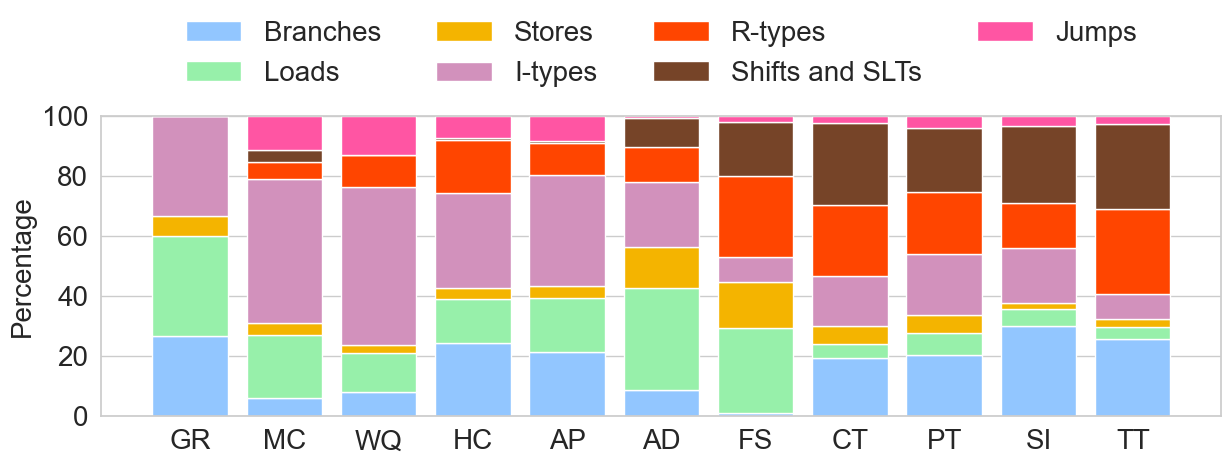

In [51]:

# Clean up workload names for plotting
def clean_workload_name(name):
    # Remove leading numbers and dots, e.g., "01. Gesture Recognition" -> "Gesture Recognition"
    return re.sub(r'^\d+\.\s*', '', name)

# Prepare data structures
instruction_data = defaultdict(lambda: defaultdict(int))
total_instructions_data = {}
workload_names = []

for idx, row in df.iterrows():
    workload = row['Workload']
    kernel = row['Kernel']
    # Combine for uniqueness if needed
    # workload_label = f"{workload}\n({kernel})"
    workload_label = SHORT_HAND_NAMES[workload]
    workload_names.append(workload_label)
    total_instructions = row['Total Number of Instructions']
    total_instructions_data[workload_label] = total_instructions
    for cat in CATEGORIES:
        instruction_data[workload_label][cat] = row[cat]

# Make sure plots directory exists
os.makedirs("plots", exist_ok=True)

# 1. Plot instruction mix (percentages) using seaborn
def plot_instruction_mix(instruction_data, total_instructions_data):
    sorted_workloads = list(instruction_data.keys())
    # Prepare DataFrame for seaborn
    records = []
    for workload in sorted_workloads:
        for category in CATEGORIES:
            percent = (instruction_data[workload][category] / total_instructions_data[workload]) * 100
            records.append({
                "Workload": clean_workload_name(workload),
                "Category": category,
                "Percent": percent
            })
    df_plot = pd.DataFrame(records)

    # Set color palette
    palette = {cat: color for cat, color in zip(CATEGORIES, CATEGORY_COLORS)}

    # Pivot for stacked bar
    df_pivot = df_plot.pivot(index="Workload", columns="Category", values="Percent").fillna(0)
    df_pivot = df_pivot.reindex([clean_workload_name(w) for w in sorted_workloads])  # Ensure workload order matches sorted_workloads
    df_pivot = df_pivot[CATEGORIES]  # Ensure category order

    # Plot
    fig, ax = plt.subplots(figsize=(16, 10))
    bottom = None
    for i, category in enumerate(CATEGORIES):
        values = df_pivot[category].values
        if i == 0:
            bars = ax.bar(df_pivot.index, values, label=category, color=palette[category])
            bottom = values
        else:
            bars = ax.bar(df_pivot.index, values, label=category, color=palette[category], bottom=df_pivot[CATEGORIES[:i]].sum(axis=1).values)
        # # Annotate
        # for bar, value in zip(bars, values):
        #     if value > 0:
        #         height = bar.get_height()
        #         ax.text(
        #             bar.get_x() + bar.get_width() / 2,
        #             bar.get_y() + height / 2,
        #             f'{value:.1f}%',
        #             ha='center',
        #             va='center',
        #             fontsize=TEXT_SIZE-2,
        #         )

    # Ensure all four borders (spines) are visible
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(True)

    ax.set_ylabel('Percentage', fontsize=TEXT_SIZE)
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.4),
        ncol=4,
        frameon=False,
        fontsize=TEXT_SIZE,
        alignment='center'
    )
    ax.set_xticks(list(range(len(df_pivot.index))))
    # ax.set_xticklabels(df_pivot.index, rotation=45, ha='right')
    plt.xticks(rotation=0, ha='center',fontsize=TEXT_SIZE)
    plt.subplots_adjust(
        top=0.80,
        bottom=0.50,
        left=0.10,
        right=0.80
    )
    plt.ylim(0, 100)
    plt.savefig("plots/instruction_mix.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Call all plots
plot_instruction_mix(instruction_data, total_instructions_data)

/var/folders/bv/n2w_m8nj73g0p2j9wwv286yw0000gn/T/ipykernel_70158/3915714864.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_workloads, rotation=0, ha='center')


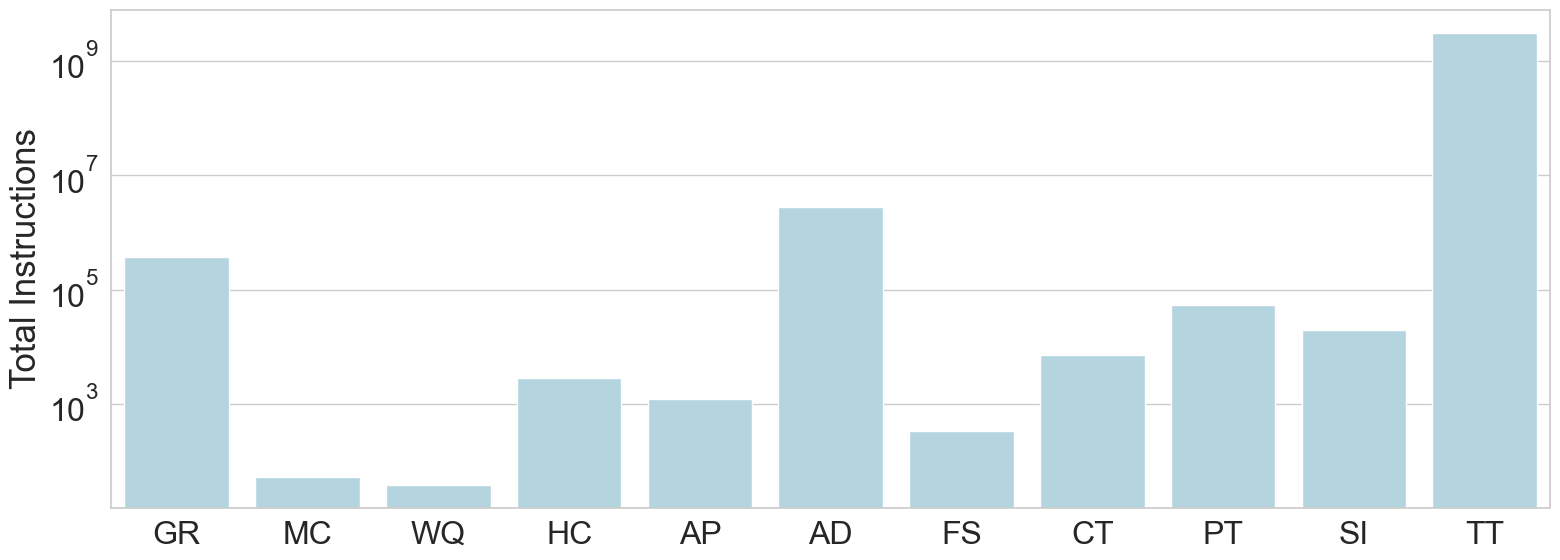

In [37]:
# 2. Plot total instructions (log scale)
def plot_total_instructions(total_instructions_data):
    sorted_workloads = list(instruction_data.keys())
    total_instructions = [total_instructions_data[workload] for workload in sorted_workloads]
    data = {
        "Workload": sorted_workloads,
        "Total Instructions": total_instructions
    }
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.barplot(
        x="Workload",
        y="Total Instructions",
        data=data,
        color='#add8e6',
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel('Total Instructions')
    # ax.set_title('Total Instruction Count of Workloads')
    ax.set_yscale("log")
    ax.set_xticklabels(sorted_workloads, rotation=0, ha='center')
    plt.tight_layout()
    plt.savefig("plots/total_instructions.pdf", dpi=300, bbox_inches='tight')
    # Optionally label bars
    # for i, bar in enumerate(ax.patches):
    #     height = bar.get_height()
    #     label_value = total_instructions[i]
    #     ax.text(
    #         bar.get_x() + bar.get_width() / 2,
    #         height + 1,
    #         f'{label_value}',
    #         ha='center',
    #         va='bottom',
    #         fontsize=9
    #     )
    plt.show()

plot_total_instructions(total_instructions_data)


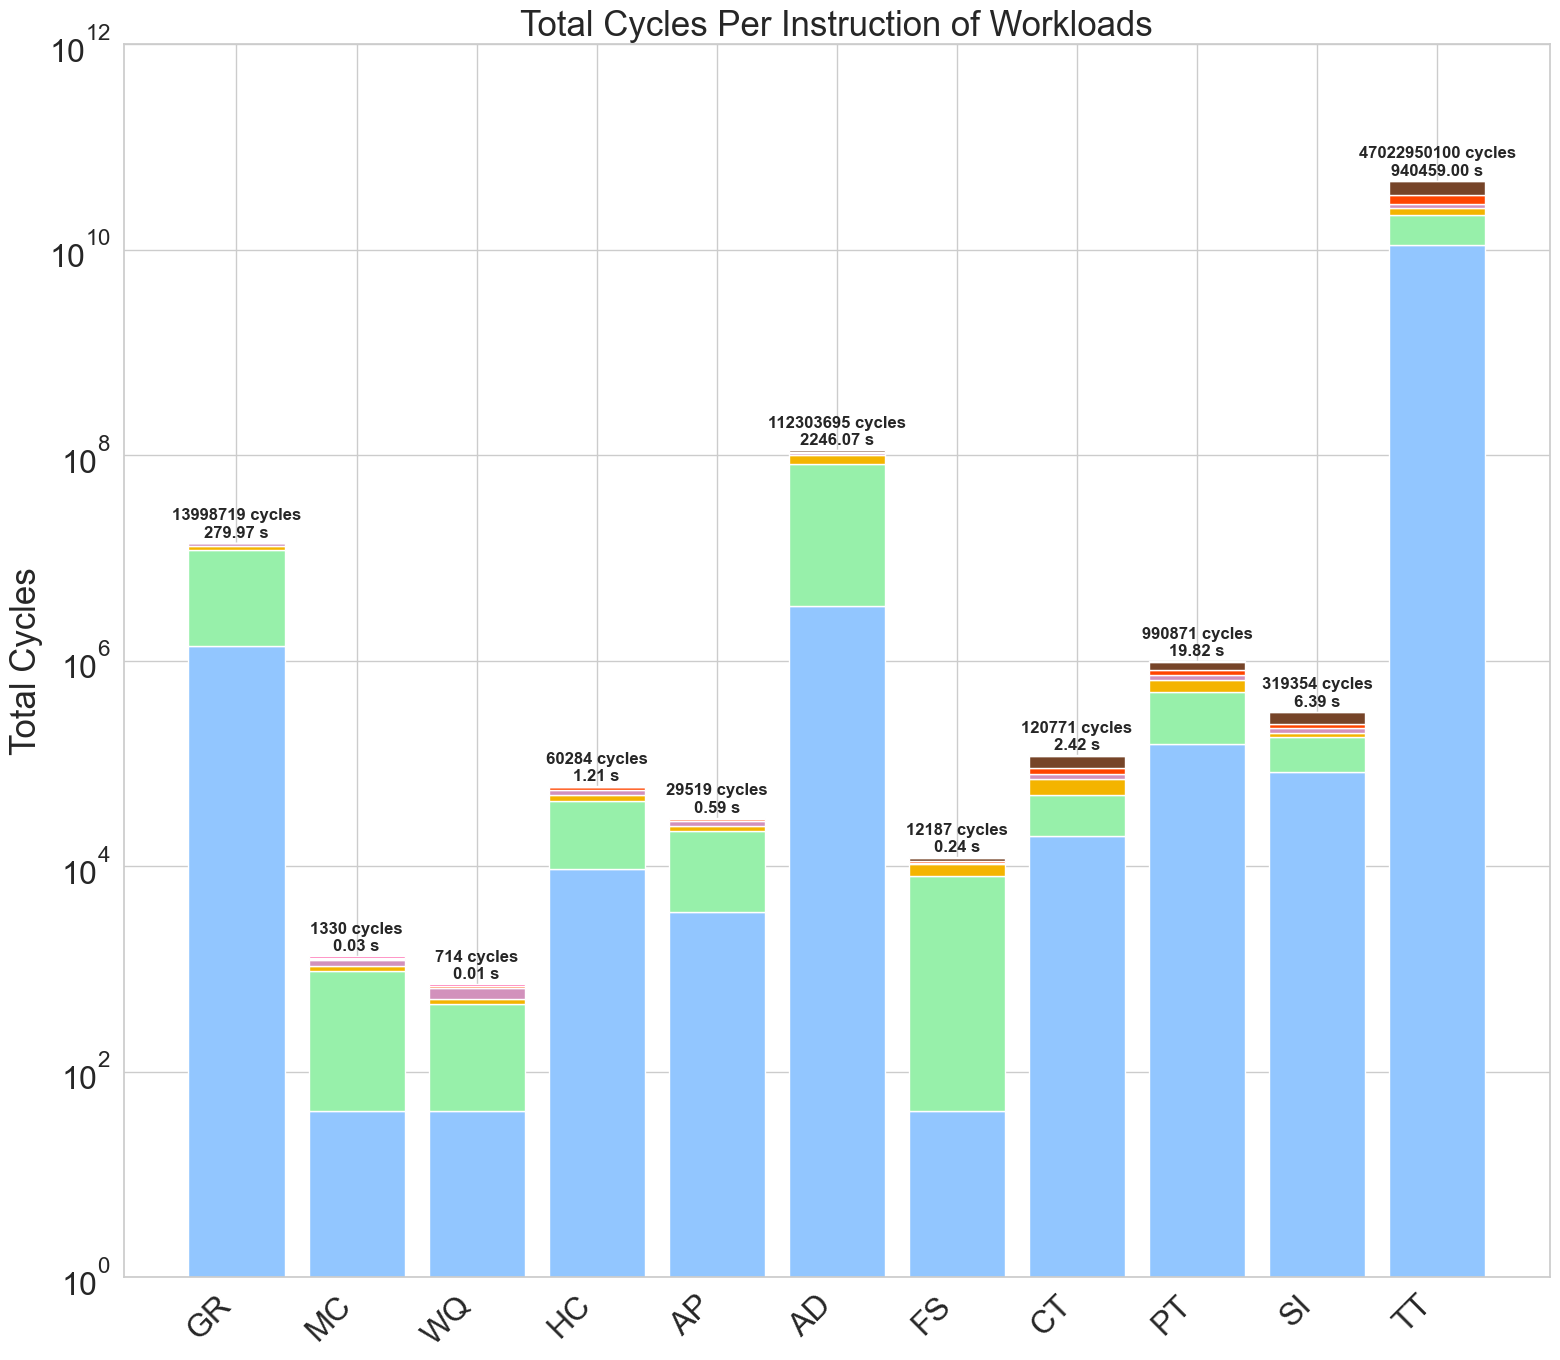

In [38]:

# 3. Plot total cycles per instruction (stacked bar, log scale) using seaborn
def plot_total_cycles_per_instruction(instruction_data, total_instructions_data, log_scale=True, clock_freq=50000):
    sorted_workloads = list(instruction_data.keys())
    records = []
    total_cycles_per_workload = {}
    for workload in sorted_workloads:
        total_cycles = 0
        for category in CATEGORIES:
            count = instruction_data[workload][category]
            cycles = count * CYCLES_PER_INSTRUCTION_BY_CORE['HERV'][category]
            records.append({
                "Workload": workload,
                "Category": category,
                "Cycles": cycles
            })
            total_cycles += cycles
        total_cycles_per_workload[workload] = total_cycles

    df = pd.DataFrame(records)
    # Pivot for stacked bar
    df_pivot = df.pivot(index="Workload", columns="Category", values="Cycles").fillna(0)
    df_pivot = df_pivot.loc[sorted_workloads]  # Ensure order

    # Plot with seaborn
    fig, ax = plt.subplots(figsize=(16, 14))
    bottom = None
    for idx, (category, color) in enumerate(zip(CATEGORIES, CATEGORY_COLORS)):
        values = df_pivot[category].values
        bars = ax.bar(df_pivot.index, values, label=category, color=color, bottom=bottom)
        if bottom is None:
            bottom = values
        else:
            bottom = bottom + values

    # Annotate with total cycles and runtime
    for i, workload in enumerate(sorted_workloads):
        total_cycles = total_cycles_per_workload[workload]
        runtime_seconds = total_cycles / clock_freq
        ax.text(i, total_cycles + 0.05 * total_cycles, f'{total_cycles:.0f} cycles\n{runtime_seconds:.2f} s', 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    if log_scale:
        ax.set_yscale('log')
    ax.set_ylabel('Total Cycles')
    ax.set_title('Total Cycles Per Instruction of Workloads')
    ax.set_ylim(1, 1e12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("plots/total_cycles_per_instruction.pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_total_cycles_per_instruction(instruction_data, total_instructions_data)


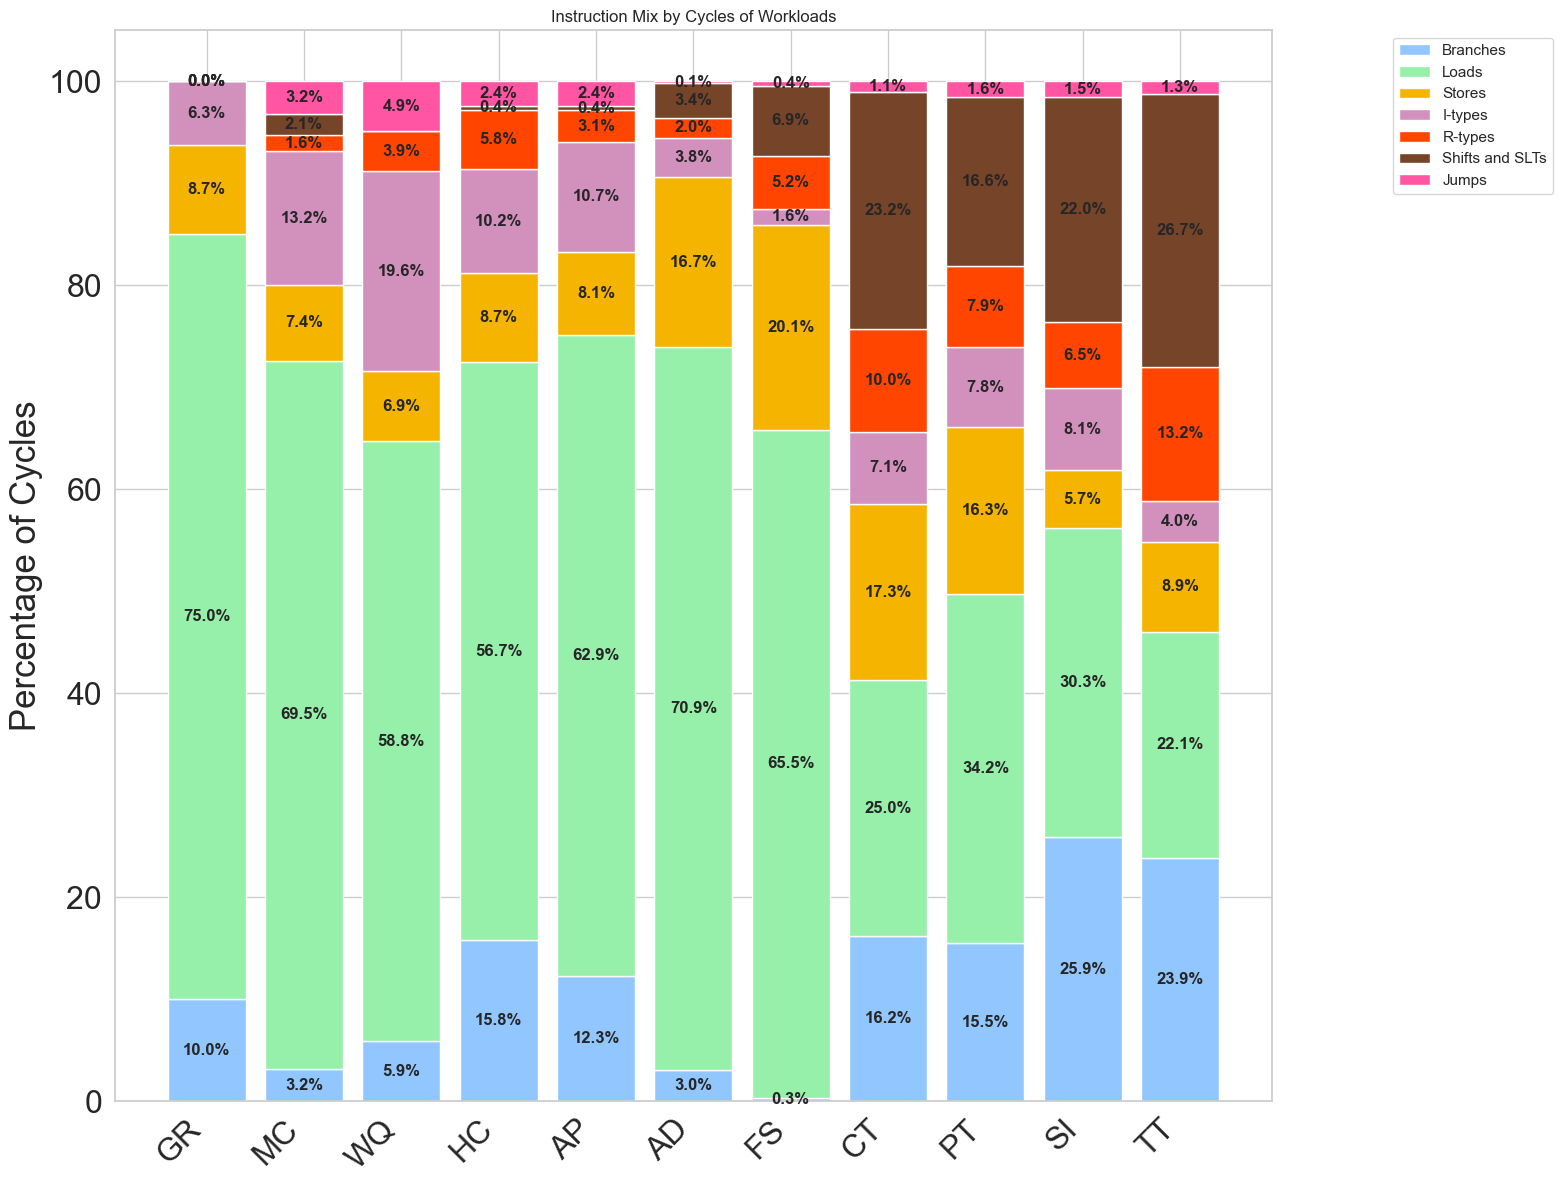

In [39]:
# 4. Plot instruction mix by cycles (percent of cycles per category) using seaborn
def plot_instruction_mix_by_cycles(instruction_data, total_instructions_data):    # Build DataFrame for seaborn
    records = []
    sorted_workloads = list(instruction_data.keys())

    for workload in sorted_workloads:
        total_cycles = sum(
            instruction_data[workload][cat] * CYCLES_PER_INSTRUCTION_BY_CORE['HERV'][cat]
            for cat in CATEGORIES
        )
        for category in CATEGORIES:
            cycles = instruction_data[workload][category] * CYCLES_PER_INSTRUCTION_BY_CORE['HERV'][category]
            percent = (cycles / total_cycles * 100) if total_cycles != 0 else 0
            records.append({
                "Workload": workload,
                "Category": category,
                "Percent": percent
            })
    df = pd.DataFrame(records)
    # Set category order for consistent coloring
    df["Category"] = pd.Categorical(df["Category"], categories=CATEGORIES, ordered=True)
    # Set color palette
    palette = {cat: color for cat, color in zip(CATEGORIES, CATEGORY_COLORS)}
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.set_theme(style="whitegrid")
    # Stacked barplot
    bottom = None
    for idx, category in enumerate(CATEGORIES):
        data = df[df["Category"] == category]
        values = data["Percent"].values
        if bottom is None:
            bars = ax.bar(sorted_workloads, values, label=category, color=palette[category])
            bottom = values
        else:
            bars = ax.bar(sorted_workloads, values, label=category, color=palette[category], bottom=bottom)
            bottom = bottom + values
        # Annotate bars
        for bar, value in zip(bars, values):
            if value > 0:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f'{value:.1f}%',
                    ha='center',
                    va='center',
                    fontsize=12,
                    fontweight='bold'
                )
    ax.set_ylabel('Percentage of Cycles')
    ax.set_title('Instruction Mix by Cycles of Workloads')
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    ax.set_ylim(0, 105)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("plots/instruction_mix_by_cycles.pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_instruction_mix_by_cycles(instruction_data, total_instructions_data)


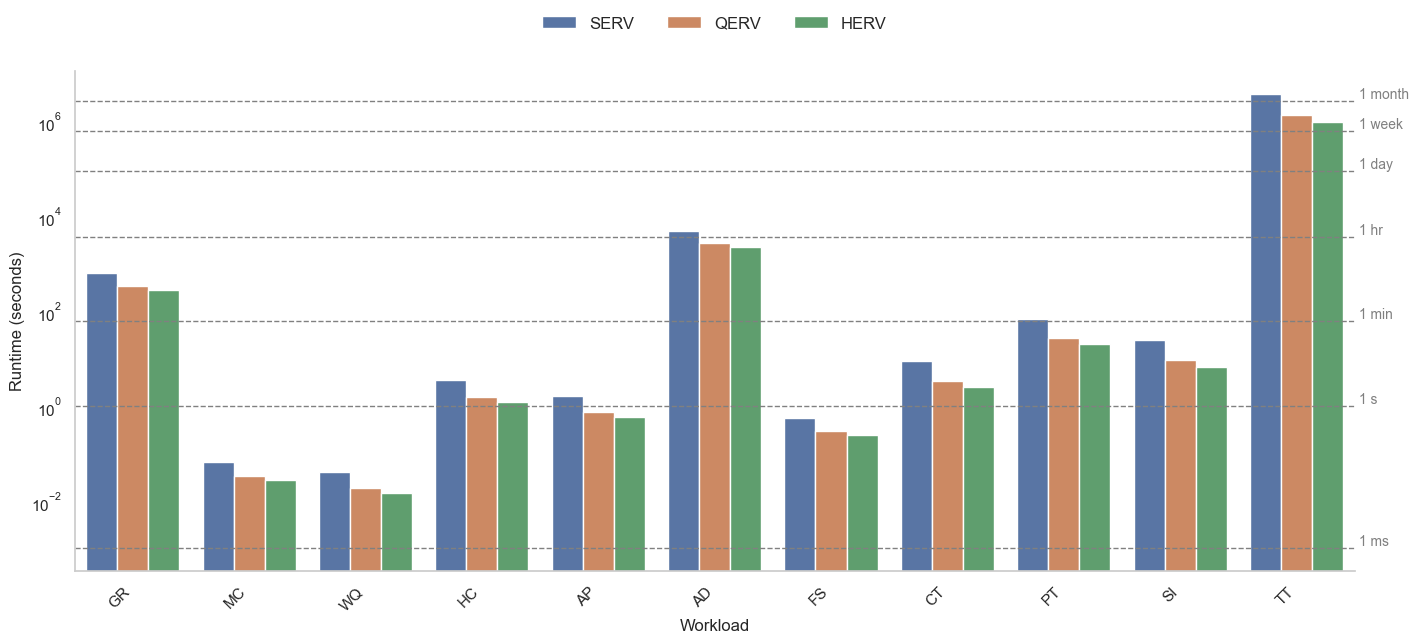

In [40]:

# 5. Plot runtime per core (SERV, QERV, HERV) using seaborn
def plot_runtime_per_core(instruction_data, clock_freq=50000, log_scale=True):
    sorted_workloads = list(instruction_data.keys())
    cores = ["SERV", "QERV", "HERV"]
    records = []
    for workload in sorted_workloads:
        for i, core in enumerate(cores):
            total_cycles = 0
            for category in CYCLES_PER_INSTRUCTION_BY_CORE[core]:
                count = instruction_data[workload].get(category, 0)
                cycles = CYCLES_PER_INSTRUCTION_BY_CORE[core][category]
                total_cycles += count * cycles
            runtime_seconds = total_cycles / clock_freq
            records.append({
                "Workload": clean_workload_name(workload),
                "Core": core,
                "Runtime (seconds)": runtime_seconds
            })
    df = pd.DataFrame(records)

    plt.figure(figsize=(16, 10))
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(
        data=df,
        x="Workload",
        y="Runtime (seconds)",
        hue="Core",
        palette=CORE_COLORS[:len(cores)],
        dodge=True
    )
    ax.set_ylabel("Runtime (seconds)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if log_scale:
        ax.set_yscale('log')
    plt.xticks(rotation=45, ha='right')
    for label, value in DUTY_CYCLE_THRESHOLDS.items():
        ax.axhline(y=value, linestyle='--', color='gray', linewidth=1)
        ax.text(len(sorted_workloads)-0.5, value, f" {label}", va='bottom', ha='left', color='gray', fontsize=10)
    ax.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=3,
        frameon=False,
        fontsize=12
    )
    ax.grid(axis='y', linestyle='', alpha=0.6)
    plt.subplots_adjust(
        top=0.9,
        bottom=0.40,
        left=0.15,
        right=0.95
    )
    plt.savefig("plots/flexibits_runtime_comparison.pdf", dpi=300)
    plt.show()

plot_runtime_per_core(instruction_data)


## Embodied, Area, and Power Footprint

In [41]:
load_embodied_values_from_csv("embodied-carbon.csv")
load_memory_from_csv("memory.csv")
load_execution_time_from_csv("timing.csv")

{'Food Spoilage Detection': {'Serv': 21868.1, 'Qerv': 6943.2, 'Herv': 4441.0},
 'Cardiotocography': {'Serv': 415668.9, 'Qerv': 131451.8, 'Herv': 83444.0},
 'Arrhythmia Detection': {'Serv': 163598847.5,
  'Qerv': 51856949.5,
  'Herv': 33142273.5},
 'Water Quality Monitoring': {'Serv': 4380.3, 'Qerv': 1402.1, 'Herv': 901.3},
 'HVAC Control': {'Serv': 124699.1, 'Qerv': 39724.1, 'Herv': 25445.8},
 'Package Tracking': {'Serv': 3059002.7, 'Qerv': 968085.25, 'Herv': 615217.85},
 'Gesture Recognition': {'Serv': 21818684.3,
  'Qerv': 6905954.1,
  'Herv': 4403825.3},
 'Air Pollution Monitoring': {'Serv': 69276.5,
  'Qerv': 22052.6,
  'Herv': 14115.6},
 'Malodor Classification': {'Serv': 5358.1, 'Qerv': 1708.2, 'Herv': 1094.4},
 'Smart Irrigation Control': {'Serv': 1097427.7,
  'Qerv': 346625.9,
  'Herv': 219609.3}}

In [42]:
TEXT_SIZE = 25
plt.rcParams.update({
    'font.size': TEXT_SIZE,
    'axes.titlesize': TEXT_SIZE,
    'axes.labelsize': TEXT_SIZE,
    'xtick.labelsize': TEXT_SIZE,
    'ytick.labelsize': TEXT_SIZE,
    'legend.fontsize': TEXT_SIZE
})


### Embodied

/var/folders/bv/n2w_m8nj73g0p2j9wwv286yw0000gn/T/ipykernel_70158/237485244.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=0, ha='center')


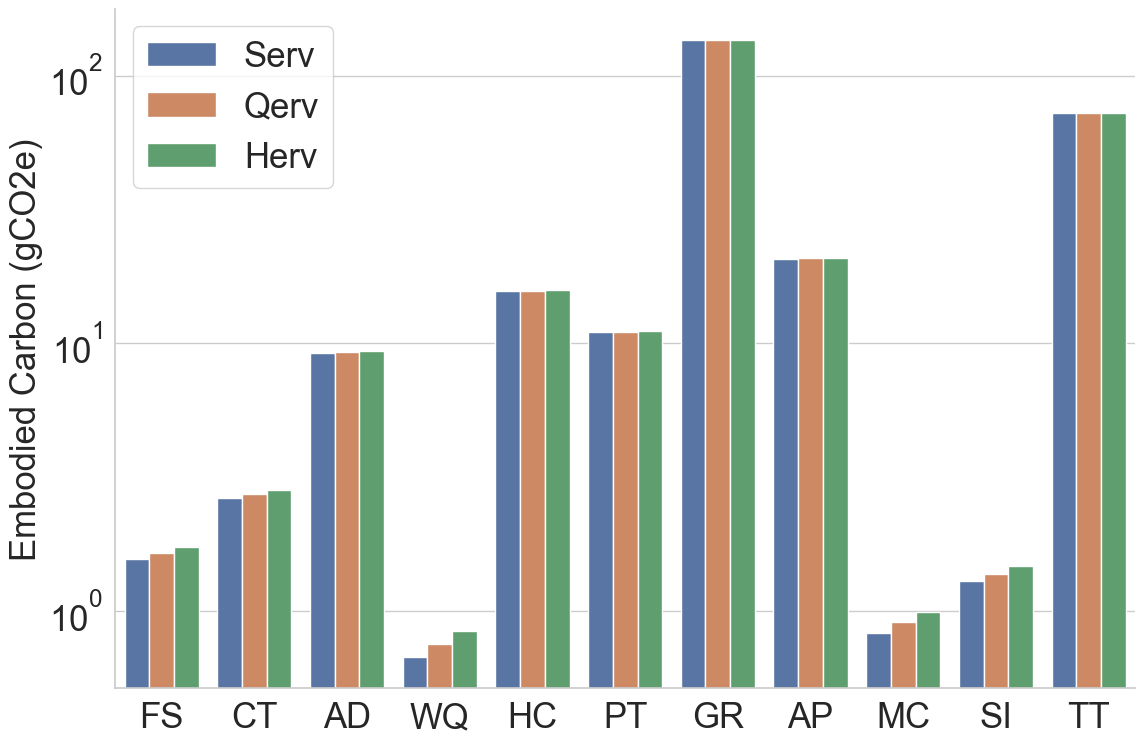

In [43]:
# Prepare data for plotting
embodied_df = pd.DataFrame(embodied_values).T.reset_index()
embodied_df = embodied_df.rename(columns={'index': 'Workload'})
embodied_df = embodied_df.melt(
    id_vars=['Workload'],
    value_vars=['Serv', 'Qerv', 'Herv'],
    var_name='System',
    value_name='Embodied Carbon (gCO2e)'
)

# Map the correct values for each system
def get_embodied(workload, system):
    return embodied_values[workload][system]['Carbon Footprint Max (gCO2e)']

embodied_df['Embodied Carbon (gCO2e)'] = [
    get_embodied(row['Workload'], row['System'])
    for _, row in embodied_df.iterrows()
]

# Sort workloads for consistent grouping
sorted_workloads = sorted(embodied_df['Workload'].unique())
system_palette = [system_colors[sys] for sys in ['Serv', 'Qerv', 'Herv']]

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=embodied_df,
    x='Workload',
    y='Embodied Carbon (gCO2e)',
    hue='System',
    palette=system_palette,
    dodge=True
)
ax.set_yscale('log')
ax.set_ylabel('Embodied Carbon (gCO2e)')
ax.set_xlabel('')
# ax.set_title('Embodied Carbon Footprint by Workload and System')

# Set x-tick labels to SHORT_HAND_NAMES
xtick_labels = [SHORT_HAND_NAMES.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(xtick_labels, rotation=0, ha='center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=True)
plt.tight_layout()
plt.savefig("plots/flexibits_embodied_footprint.pdf", dpi=300)
plt.show()


### Area and Power

In [44]:
# Load the embodied carbon CSV (if not already loaded)
embodied_area_df = pd.read_csv("embodied-carbon.csv")

# Prepare data for stacked percent bar chart
systems = ['Serv', 'Qerv', 'Herv']

TEXT_SIZE = 30
plt.rcParams.update({
    'font.size': TEXT_SIZE,
    'axes.titlesize': TEXT_SIZE,
    'axes.labelsize': TEXT_SIZE,
    'xtick.labelsize': TEXT_SIZE,
    'ytick.labelsize': TEXT_SIZE,
    'legend.fontsize': TEXT_SIZE
})



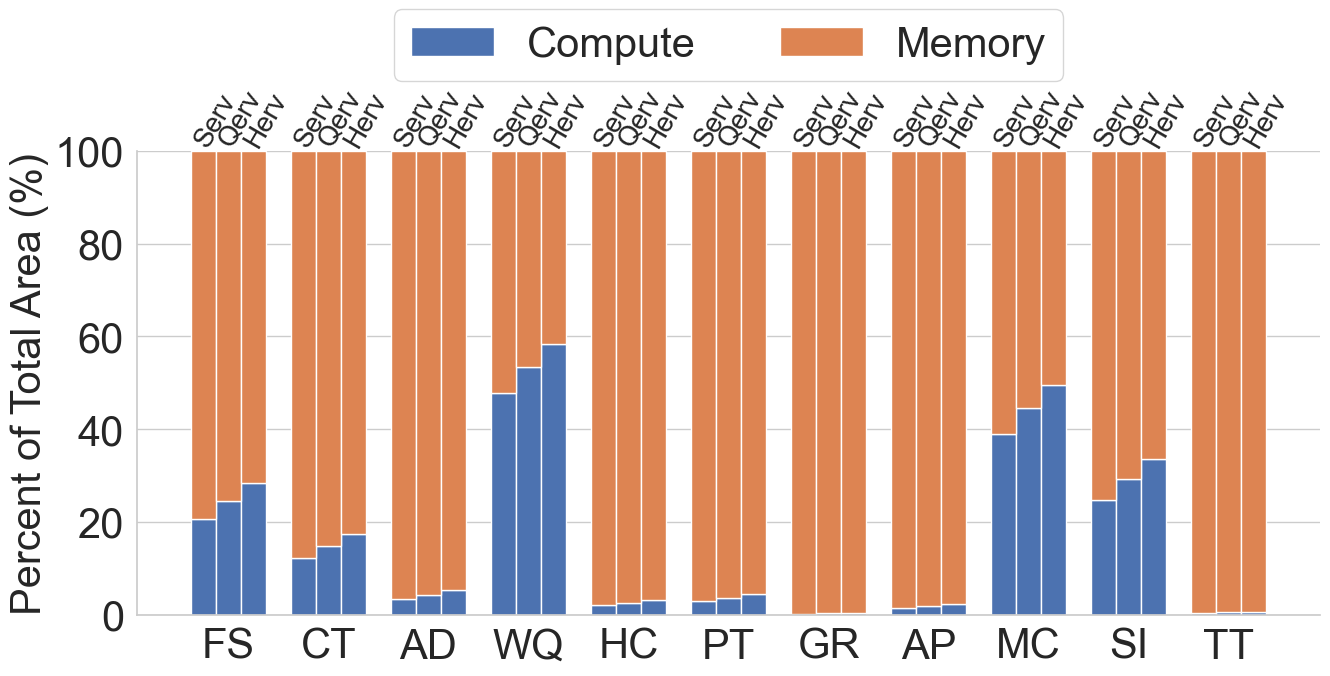

In [45]:

area_components = ['Compute Area (mm^2)', 'Memory Area (mm^2)']

# Preserve the order of workloads as they appear in the CSV
workload_order = []
seen_workloads = set()
for _, row in embodied_area_df.iterrows():
    workload = row['Workload']
    if workload not in seen_workloads:
        workload_order.append(workload)
        seen_workloads.add(workload)

# For each system, calculate percent of total area for compute and memory
plot_data = []
for _, row in embodied_area_df.iterrows():
    for sys in systems:
        if row['CPU Design'] == sys:
            total_area = row['Total Area (mm^2)']
            compute_pct = row['Compute Area (mm^2)'] / total_area * 100
            memory_pct = row['Memory Area (mm^2)'] / total_area * 100
            plot_data.append({
                'Workload': row['Workload'],
                'System': sys,
                'Component': 'Compute',
                'Percent Area': compute_pct
            })
            plot_data.append({
                'Workload': row['Workload'],
                'System': sys,
                'Component': 'Memory',
                'Percent Area': memory_pct
            })

plot_df = pd.DataFrame(plot_data)

# Ensure plot_df['Workload'] is a categorical with the original CSV order
plot_df['Workload'] = pd.Categorical(plot_df['Workload'], categories=workload_order, ordered=True)

# Use the preserved order for plotting
sorted_workloads = workload_order
system_order = ['Serv', 'Qerv', 'Herv']
component_colors = {'Compute': '#4c72b0', 'Memory': '#dd8452'}

# Create a grouped stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.25
n_systems = len(system_order)
n_workloads = len(sorted_workloads)

# Calculate group centers so that the workload label is centered under the 3 bars
group_centers = [i for i in range(n_workloads)]
# The bars for each workload are centered at: group_center - bar_width + j*bar_width, for j in 0..2

# Prepare bottom values for stacking
bottoms = {}
for sys in system_order:
    bottoms[sys] = [0] * n_workloads

# Plot bars
for comp in ['Compute', 'Memory']:
    for j, sys in enumerate(system_order):
        y = []
        for i, workload in enumerate(sorted_workloads):
            val = plot_df[
                (plot_df['Workload'] == workload) &
                (plot_df['System'] == sys) &
                (plot_df['Component'] == comp)
            ]['Percent Area']
            y.append(val.values[0] if not val.empty else 0)
        # Calculate the x positions for each system within each workload group
        x_pos = [i - bar_width + j * bar_width for i in range(n_workloads)]
        ax.bar(
            x_pos,
            y,
            bar_width,
            label=f"{sys} {comp}" if comp == 'Compute' else None,
            color=component_colors[comp],
            bottom=bottoms[sys]
        )
        # Update bottoms for stacking
        bottoms[sys] = [bottoms[sys][k] + y[k] for k in range(len(y))]

# Custom legend
legend_elements = [
    Patch(facecolor=component_colors['Compute'], label='Compute'),
    Patch(facecolor=component_colors['Memory'], label='Memory')
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)

# Set x-ticks at the center of each workload group
ax.set_xticks(group_centers)
# Set x-tick labels to SHORT_HAND_NAMES if available
xtick_labels = [SHORT_HAND_NAMES.get(w, w) for w in sorted_workloads]
ax.set_xticklabels(xtick_labels, rotation=0, ha='center')

# Optionally, annotate system names above each bar
for i, workload in enumerate(sorted_workloads):
    for j, sys in enumerate(system_order):
        xpos = i - bar_width + j * bar_width + bar_width/2
        ax.text(xpos, 100, sys, ha='center', va='bottom', fontsize=TEXT_SIZE-10, rotation=60)

ax.set_ylabel('Percent of Total Area (%)')
ax.set_xlabel('')
ax.set_ylim(0, 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)  # Remove the vertical axis grid

plt.tight_layout()
plt.savefig("plots/flexibits_area_percent_stacked.pdf", dpi=300)
plt.show()


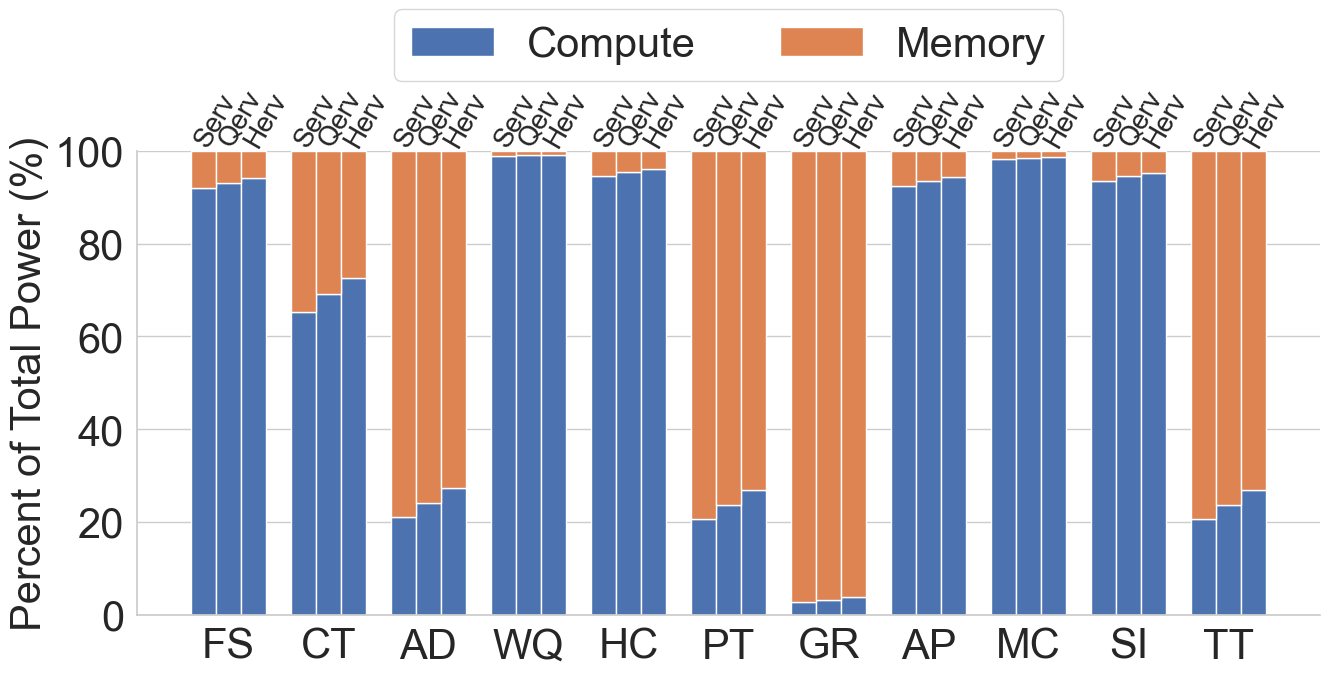

In [46]:
# Power breakdown plot (Compute vs Memory) for each system and workload

power_components = ['Compute Power (W)', 'Memory Power (W)']

power_plot_data = []
workload_order_power = []
seen_workloads_power = set()

for _, row in embodied_area_df.iterrows():
    workload = row['Workload']
    if workload not in seen_workloads_power:
        workload_order_power.append(workload)
        seen_workloads_power.add(workload)
    for sys in systems:
        if row['CPU Design'] == sys:
            # Get system power (compute)
            system_power = system_specs[sys]["power"]
            # Get memory parameters from sram and lprom dictionaries
            sram_bytes = sram[workload]
            lprom_bytes = lprom[workload]
            # Compute memory power
            memory_power = (sram_power + sram_overhead_power) * sram_bytes * 8 + lprom_power * lprom_bytes * 8
            total_power = system_power + memory_power

            compute_pct = system_power / total_power * 100 if total_power > 0 else 0
            memory_pct = memory_power / total_power * 100 if total_power > 0 else 0

            power_plot_data.append({
                'Workload': workload,
                'System': sys,
                'Component': 'Compute',
                'Percent Power': compute_pct
            })
            power_plot_data.append({
                'Workload': workload,
                'System': sys,
                'Component': 'Memory',
                'Percent Power': memory_pct
            })

power_plot_df = pd.DataFrame(power_plot_data)
power_plot_df['Workload'] = pd.Categorical(power_plot_df['Workload'], categories=workload_order_power, ordered=True)

# Use the preserved order for plotting
sorted_workloads_power = workload_order_power
system_order_power = ['Serv', 'Qerv', 'Herv']
component_colors_power = {'Compute': '#4c72b0', 'Memory': '#dd8452'}

# Create a grouped stacked bar chart for power
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.25
n_systems = len(system_order_power)
n_workloads = len(sorted_workloads_power)

# Calculate group centers so that x labels are centered under the 3 bars
group_centers = [i for i in range(n_workloads)]

# Prepare bottom values for stacking
bottoms = {}
for sys in system_order_power:
    bottoms[sys] = [0] * n_workloads

# Plot bars
for comp in ['Compute', 'Memory']:
    for j, sys in enumerate(system_order_power):
        y = []
        for i, workload in enumerate(sorted_workloads_power):
            val = power_plot_df[
                (power_plot_df['Workload'] == workload) &
                (power_plot_df['System'] == sys) &
                (power_plot_df['Component'] == comp)
            ]['Percent Power']
            y.append(val.values[0] if not val.empty else 0)
        # Calculate x positions for each system within each workload group
        x_pos = [i - bar_width + j * bar_width for i in range(n_workloads)]
        ax.bar(
            x_pos,
            y,
            bar_width,
            label=f"{sys} {comp}" if comp == 'Compute' else None,
            color=component_colors_power[comp],
            bottom=bottoms[sys]
        )
        # Update bottoms for stacking
        bottoms[sys] = [bottoms[sys][k] + y[k] for k in range(len(y))]

# Custom legend
legend_elements = [
    Patch(facecolor=component_colors_power['Compute'], label='Compute'),
    Patch(facecolor=component_colors_power['Memory'], label='Memory')
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)

# Set x-ticks at the center of each workload group
ax.set_xticks(group_centers)
# Set x-tick labels to SHORT_HAND_NAMES if available, centered under the 3 bars
xtick_labels = [SHORT_HAND_NAMES.get(w, w) for w in sorted_workloads_power]
ax.set_xticklabels(xtick_labels, rotation=0, ha='center')

# Optionally, annotate system names above each bar
for i, workload in enumerate(sorted_workloads_power):
    for j, sys in enumerate(system_order_power):
        xpos = i - bar_width + j * bar_width + bar_width/2
        ax.text(xpos, 100, sys, ha='center', va='bottom', fontsize=TEXT_SIZE-10, rotation=60)

ax.set_ylabel('Percent of Total Power (%)')
ax.set_xlabel('')
ax.set_ylim(0, 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)  # Remove the vertical axis grid

plt.tight_layout()
plt.savefig("plots/flexibits_power_percent_stacked.pdf", dpi=300)
plt.show()


## Runtime

In [47]:
TEXT_SIZE = 20
plt.rcParams.update({
    'font.size': TEXT_SIZE,
    'axes.titlesize': TEXT_SIZE,
    'axes.labelsize': TEXT_SIZE,
    'xtick.labelsize': TEXT_SIZE,
    'ytick.labelsize': TEXT_SIZE,
    'legend.fontsize': TEXT_SIZE
})


/var/folders/bv/n2w_m8nj73g0p2j9wwv286yw0000gn/T/ipykernel_70158/979905538.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=0, ha='center')


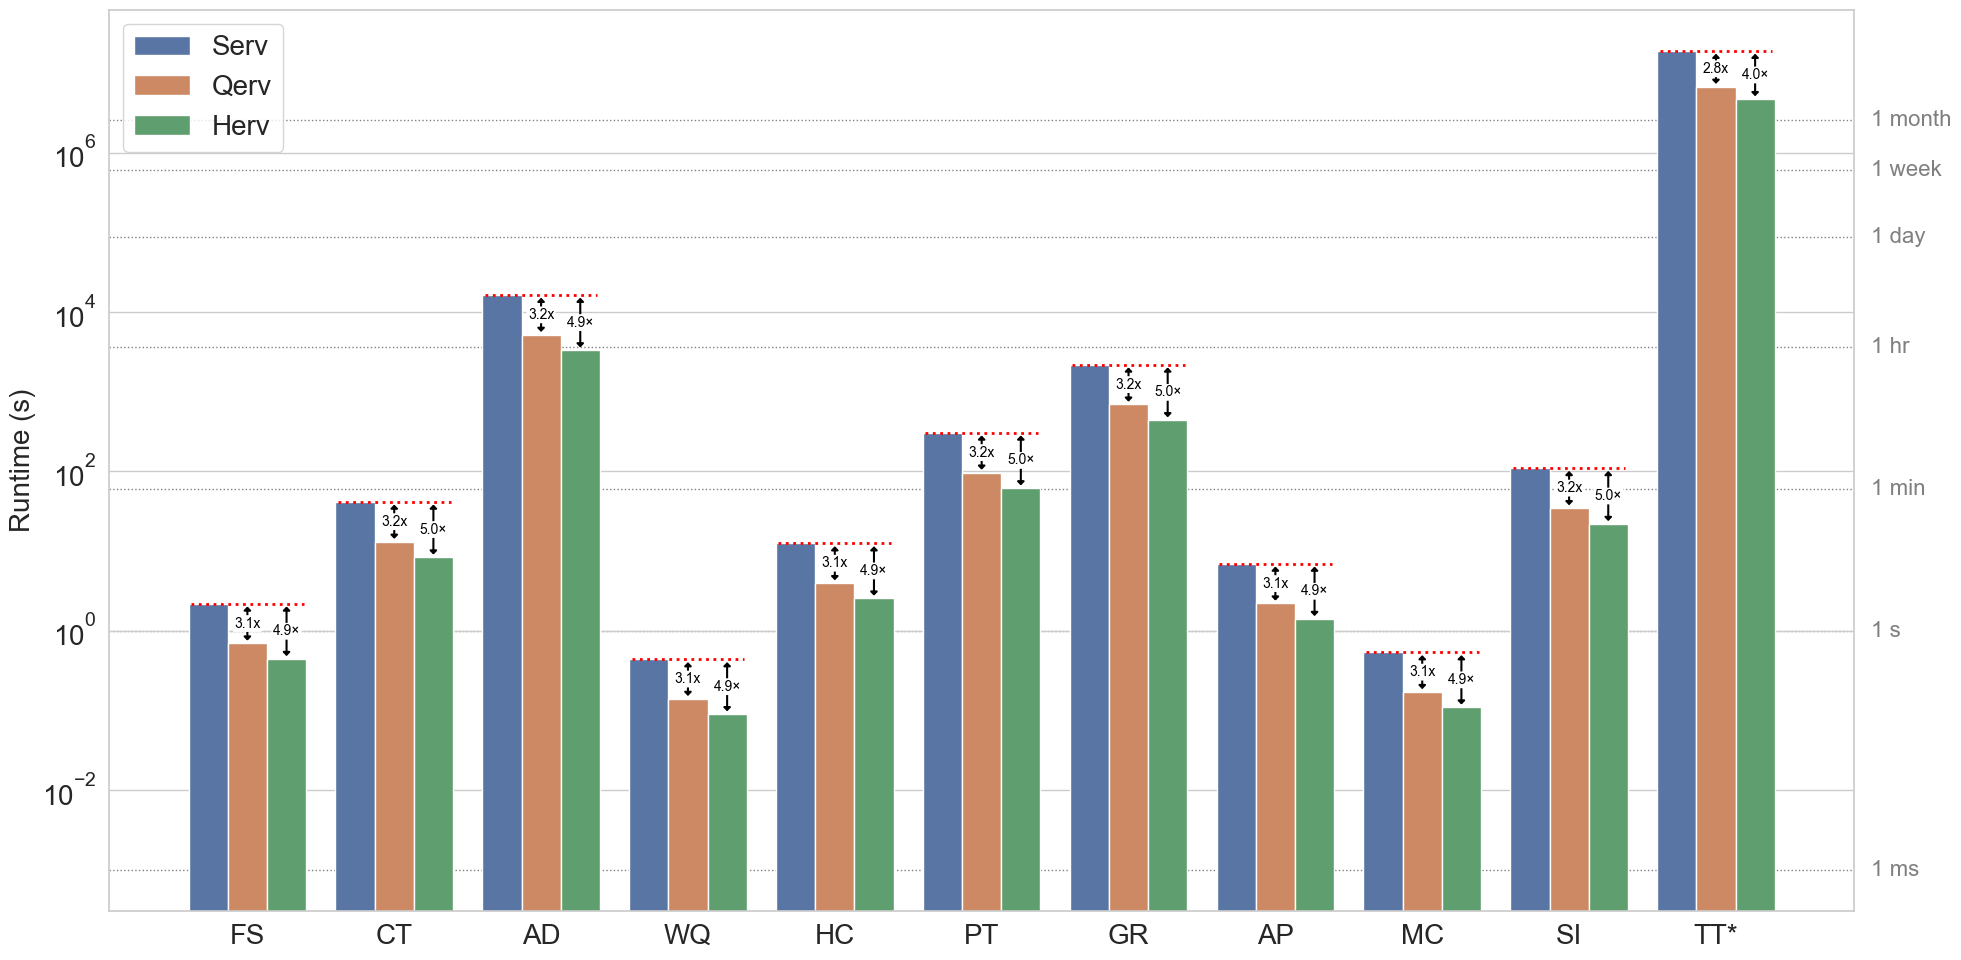

In [48]:
def plot_runtime_per_workload_log():
    import scipy.stats

    workloads = list(execution_time.keys())
    systems = ["Serv", "Qerv", "Herv"]
    core_freq = 10000

    # Use system_colors for consistent coloring
    palette = [system_colors[sys] for sys in systems]

    data = []
    for workload in workloads:
        for system in systems:
            try:
                runtime = execution_time[workload][system] / core_freq
            except KeyError:
                runtime = np.nan
            data.append({
                "Workload": workload,
                "System": system,
                "Runtime": runtime
            })

    tree_tracking_times = {
        "Serv": 3.770991e+06 * 50000 / core_freq,
        "Qerv": 1.344821e+06 * 50000 / core_freq,
        "Herv": 9.404590e+05 * 50000 / core_freq
    }

    data.append({
        "Workload": "Tree Tracking*",
        "System": "Serv",
        "Runtime": tree_tracking_times["Serv"]
    })
    data.append({
        "Workload": "Tree Tracking*",
        "System": "Qerv",
        "Runtime": tree_tracking_times["Qerv"]
    })
    data.append({
        "Workload": "Tree Tracking*",
        "System": "Herv",
        "Runtime": tree_tracking_times["Herv"]
    })

    df = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(20, 10))
    barplot = sns.barplot(
        data=df,
        x="Workload",
        y="Runtime",
        hue="System",
        ax=ax,
        palette=palette
    )

    # --- Add red dotted line at Serv bar top, and double-sided arrows down to Qerv and Herv for each workload ---
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    workload_to_xtick = {w: i for i, w in enumerate(xtick_labels)}

    bar_containers = ax.containers
    # bar_containers[0] = Serv, [1] = Qerv, [2] = Herv

    for i, workload in enumerate(xtick_labels):
        if workload == "Tree Tracking*":
            serv_runtime = tree_tracking_times["Serv"]
            qerv_runtime = tree_tracking_times["Qerv"]
            herv_runtime = tree_tracking_times["Herv"]
        else:
            serv_runtime = execution_time[workload]["Serv"] / core_freq
            qerv_runtime = execution_time[workload]["Qerv"] / core_freq
            herv_runtime = execution_time[workload]["Herv"] / core_freq
        serv_bar = bar_containers[0].patches[i]
        qerv_bar = bar_containers[1].patches[i]
        herv_bar = bar_containers[2].patches[i]

        # Get the center x position of each bar
        serv_x = serv_bar.get_x() + serv_bar.get_width() / 2
        qerv_x = qerv_bar.get_x() + qerv_bar.get_width() / 2
        herv_x = herv_bar.get_x() + herv_bar.get_width() / 2

        # Draw a red dotted line horizontally across the Serv bar
        # The line should span from just before the Qerv bar to just after the Herv bar
        min_x = min(serv_x, qerv_x, herv_x)
        max_x = max(serv_x, qerv_x, herv_x)
        line_pad = (max_x - min_x) * 0.22  # pad a bit on each side
        ax.hlines(
            y=serv_runtime,
            xmin=min_x - line_pad,
            xmax=max_x + line_pad,
            colors='red',
            linestyles='dotted',
            linewidth=2,
            zorder=10
        )

        # For Qerv
        speedup_qerv = serv_runtime / qerv_runtime
        # Calculate the midpoint for the arrow and text
        mid_y_qerv = qerv_runtime * (speedup_qerv)**.5
        # Draw the double-sided arrow
        ax.annotate(
            '',
            xy=(qerv_x, qerv_runtime),
            xytext=(qerv_x, serv_runtime),
            arrowprops=dict(
                arrowstyle='<|-|>,head_length=.1,head_width=.1',
                color='black',
                lw=1.5,
                linestyle='-',
                shrinkA=2,
                shrinkB=2,
                fill=True
            ),
            annotation_clip=False
        )
        # Place the speedup text centered on the arrow, with a white background to "interrupt" the arrow
        ax.text(
            qerv_x,
            mid_y_qerv,
            f"{speedup_qerv:.1f}x",
            ha='center', va='center', fontsize=10, color='black', rotation=0,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=1)
        )

        # For Herv
        speedup_herv = serv_runtime / herv_runtime
        mid_y_herv = herv_runtime * (speedup_herv)**.5
        ax.annotate(
            '',
            xy=(herv_x, herv_runtime),
            xytext=(herv_x, serv_runtime),
            arrowprops=dict(
                arrowstyle='<|-|>,head_length=.1,head_width=.1',
                color='black',
                lw=1.5,
                linestyle='-',
                shrinkA=2,
                shrinkB=2,
                fill=True
            ),
            annotation_clip=False
        )
        ax.text(
            herv_x,
            mid_y_herv,
            f"{speedup_herv:.1f}×",
            ha='center', va='center', fontsize=10, color='black', rotation=0,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=1)
        )

    for i, (label, yval) in enumerate(DUTY_CYCLE_THRESHOLDS.items()):
        ax.axhline(
            y=yval,
            color='gray',
            linestyle=':',
            linewidth=1,
            zorder=0
        )
        # Add the label as text on the y-axis at the corresponding y position
        ax.text(
            1.01,  # x position just outside the right edge (axes fraction)
            yval,
            f"{label}",
            va='center',
            ha='left',
            color='gray',
            fontsize=TEXT_SIZE-4,
            transform=ax.get_yaxis_transform(),
            clip_on=False
        )

        

    ax.set_yscale('log')
    ax.set_ylabel('Runtime (s)')
    xtick_labels = [SHORT_HAND_NAMES.get(w, w) for w in sorted_workloads_power]
    xtick_labels[10] = "TT*"
    ax.set_xticklabels(xtick_labels, rotation=0, ha='center')

    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel("")
    ax.legend(loc="upper left")
    plt.tight_layout()

    return fig,ax

# Example usage:
fig, ax = plot_runtime_per_workload_log()
fig.savefig("plots/flexibench_runtime_cycle_accurate.pdf", bbox_inches='tight')


In [49]:
serv_cycles = []
qerv_cycles = []
herv_cycles = []
for workload in list(execution_time.keys()):
    total_instructions = df.loc[df['Workload'] == workload, 'Total Number of Instructions'].values[0]
    serv_cycles.append(total_instructions / execution_time[workload]["Serv"])
    qerv_cycles.append(total_instructions / execution_time[workload]["Qerv"])
    herv_cycles.append(total_instructions / execution_time[workload]["Herv"])

serv_ipc = np.array(serv_cycles)
qerv_ipc = np.array(qerv_cycles)
herv_ipc = np.array(herv_cycles)

# Compute speedups for each workload
speedups_qerv = qerv_ipc / serv_ipc
speedups_herv = herv_ipc / serv_ipc

# Compute geometric mean of speedups
geo_mean_speedup_qerv = np.exp(np.mean(np.log(speedups_qerv)))
geo_mean_speedup_herv = np.exp(np.mean(np.log(speedups_herv)))

print(f"Geomean speedup (Serv → Qerv): {geo_mean_speedup_qerv:.2f}")
print(f"Geomean speedup (Serv → Herv): {geo_mean_speedup_herv:.2f}")

print(f"ETS (Serv → Qerv): {len(speedups_qerv)/np.sum(1/speedups_qerv):.2f}")
print(f"ETS (Serv → Herv): {len(speedups_herv)/np.sum(1/speedups_herv):.2f}")

serv_IPC = len(serv_ipc) / np.sum(1/serv_ipc)
qerv_IPC = len(qerv_ipc) / np.sum(1/qerv_ipc)
herv_IPC = len(herv_ipc) / np.sum(1/herv_ipc)

print(f"EWS (Serv → Qerv): {qerv_IPC/serv_IPC:.2f}")
print(f"EWS (Serv → Herv): {herv_IPC/serv_IPC:.2f}")

    

Geomean speedup (Serv → Qerv): 3.15
Geomean speedup (Serv → Herv): 4.93
ETS (Serv → Qerv): 3.15
ETS (Serv → Herv): 4.93
EWS (Serv → Qerv): 3.15
EWS (Serv → Herv): 4.92


## Scaling

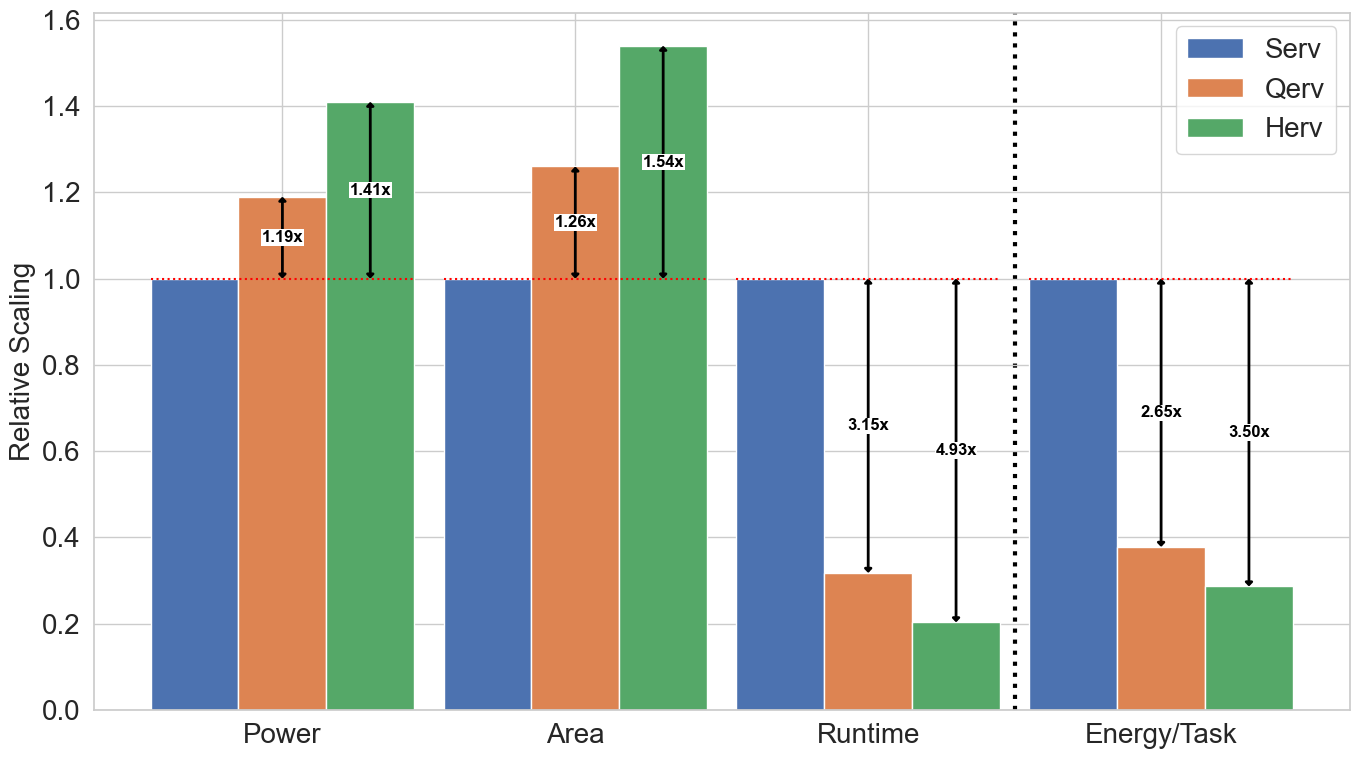

In [50]:
speedup_qerv = 3.15
speedup_herv = 4.93

power_qerv = 1.19
power_herv = 1.41

area_qerv = 1.26
area_herv = 1.54

scaling_metrics = {
    'Power': {
        'Serv': 1,
        'Qerv': power_qerv,
        'Herv': power_herv
    },
    'Area': {
        'Serv': 1,
        'Qerv': area_qerv,
        'Herv': area_herv
    },
    'Runtime': {
        'Serv': 1.0,
        'Qerv': 1 / speedup_qerv,
        'Herv': 1 / speedup_herv
    },
    'Energy/Task': {
        'Serv': 1,
        'Qerv': power_qerv / speedup_qerv,
        'Herv': power_herv / speedup_herv
    }
}

# Option to control annotation style
show_exact_values = False  # Set to True to show values, False for lines/arrows

# system_colors dictionary (should be defined elsewhere in your notebook)
# Example:
# system_colors = {'Serv': '#1f77b4', 'Qerv': '#ff7f0e', 'Herv': '#2ca02c'}

metrics = list(scaling_metrics.keys())
systems = ['Serv', 'Qerv', 'Herv']
bar_width = 0.3
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(14, 8))

# Draw bars
for i, system in enumerate(systems):
    values = [scaling_metrics[metric][system] for metric in metrics]
    ax.bar(x + (i - 1) * bar_width, values, width=bar_width, label=system, color=system_colors[system])

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=0, ha='center')
ax.tick_params(axis='y')

# Add y-label
ax.set_ylabel('Relative Scaling')

# Add legend
ax.legend()

if show_exact_values:
    # Annotate bars with values
    for i, system in enumerate(systems):
        values = [scaling_metrics[metric][system] for metric in metrics]
        for j, val in enumerate(values):
            ax.text(x[j] + (i - 1) * bar_width, val, f"{val:.2f}", ha='center', va='bottom', fontsize=10)
else:
    # Draw dotted red lines from Serv bars, and arrows to Qerv/Herv bars with relative speedup
    for j, metric in enumerate(metrics):
        serv_val = scaling_metrics[metric]['Serv']
        qerv_val = scaling_metrics[metric]['Qerv']
        herv_val = scaling_metrics[metric]['Herv']
        serv_x = x[j] + (0 - 1) * bar_width
        qerv_x = x[j] + (1 - 1) * bar_width
        herv_x = x[j] + (2 - 1) * bar_width

        # Draw dotted red horizontal line at Serv bar
        ax.hlines(serv_val, serv_x - bar_width/2, herv_x + bar_width/2, colors='red', linestyles='dotted', linewidth=1.5, zorder=5)

        # Draw arrows from Serv to Qerv and Herv
        # Qerv
        ax.annotate(
            '', 
            xy=(qerv_x, qerv_val), 
            xytext=(qerv_x, serv_val), 
            arrowprops=dict(
                arrowstyle='<|-|>,head_length=.1,head_width=.1',
                color='black',
                lw=2,
                shrinkA=0,
                shrinkB=0,
                linestyle='-'),
            annotation_clip=False
        )
        # Herv
        ax.annotate(
            '', 
            xy=(herv_x, herv_val), 
            xytext=(herv_x, serv_val), 
            arrowprops=dict(
                arrowstyle='<|-|>,head_length=.1,head_width=.1',
                color='black',
                lw=2,
                shrinkA=0,
                shrinkB=0,
                linestyle='-'),
            annotation_clip=False
        )

        # Compute and label relative values
        rel_qerv = qerv_val / serv_val if serv_val != 0 else float('nan')
        rel_herv = herv_val / serv_val if serv_val != 0 else float('nan')

        # Place label for Qerv arrow
        mid_qerv_y = (serv_val + qerv_val) / 2
        ax.text(
            qerv_x, 
            mid_qerv_y, 
            f"{(rel_qerv if rel_qerv > 1/rel_qerv else 1/rel_qerv):.2f}x", 
            color='black', 
            fontsize=TEXT_SIZE-8, 
            ha='center', 
            va='center',
            fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=0.5)
        )

        # Place label for Herv arrow
        mid_herv_y = (serv_val + herv_val) / 2
        ax.text(
            herv_x, 
            mid_herv_y, 
            f"{(rel_herv if rel_herv > 1/rel_herv else 1/rel_herv):.2f}x", 
            color='black', 
            fontsize=TEXT_SIZE-8, 
            ha='center', 
            va='center',
            fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=0.5)
        )

split_x = 2.5
ax.axvline(x=split_x, color='black', linestyle=':', linewidth=3, ymin=0, ymax=1, zorder=0)

plt.tight_layout()
# plt.title("Scaling of Power, Geomean Speedup, Area, and Relative Energy/Inference", fontsize=14)
plt.savefig("plots/scaling.pdf", format="pdf")
plt.show()

